## Week 3 Project Task - DMNN 

#### Task 1 — Re-establish Your Modelling Dataset

In [51]:
import os
os.listdir()


['check_columns.py',
 'COLUMN_NAMES_REFERENCE.md',
 'column_reference.md',
 'dmm.ipynb',
 'online_retail_II.csv',
 'test_datetime.py']

In [52]:
import pandas as pd

# -----------------------------
# Load Dataset
# -----------------------------


# -----------------------------
# Basic Inspection (Good Practice)
# -----------------------------
print("Original Shape:", df.shape)
print(df.head())

# -----------------------------
# Cleaning Based on Week 1
# -----------------------------

# Remove missing Customer IDs
df = df.dropna(subset=['Customer ID'])

# Remove cancelled invoices (start with 'C')
df = df[~df['Invoice'].astype(str).str.startswith('C')]

# Remove negative or zero quantities and prices
df = df[(df['Quantity'] > 0) & (df['Price'] > 0)]

# Fix data types
df['Customer ID'] = df['Customer ID'].astype(int)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], dayfirst=True)

# -----------------------------
# Create Transaction Value
# -----------------------------
df['TotalPrice'] = df['Quantity'] * df['Price']

# -----------------------------
# Aggregate to Customer Level
# (YOUR UNIT OF ANALYSIS)
# -----------------------------
customer_df = df.groupby('Customer ID').agg(
    total_spent=('TotalPrice', 'sum'),
    avg_spent=('TotalPrice', 'mean'),
    purchase_frequency=('Invoice', 'nunique'),
    total_items=('Quantity', 'sum'),
    avg_basket_size=('Quantity', 'mean'),
    last_purchase=('InvoiceDate', 'max')
).reset_index()

# -----------------------------
# Create Recency Feature
# -----------------------------
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

customer_df['recency_days'] = (
    snapshot_date - customer_df['last_purchase']
).dt.days

customer_df.drop(columns='last_purchase', inplace=True)

# -----------------------------
# Final Checks (Professors Like This)
# -----------------------------
print("Model-ready dataset shape:", customer_df.shape)
print("Number of customers:", customer_df.shape[0])



Original Shape: (407664, 9)
  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

          InvoiceDate  Price  Customer ID         Country  TotalPrice  
0 2009-12-01 07:45:00   6.95        13085  United Kingdom        83.4  
1 2009-12-01 07:45:00   6.75        13085  United Kingdom        81.0  
2 2009-12-01 07:45:00   6.75        13085  United Kingdom        81.0  
3 2009-12-01 07:45:00   2.10        13085  United Kingdom       100.8  
4 2009-12-01 07:45:00   1.25        13085  United Kingdom        30.0  
Model-ready dataset shape: (4312, 7)
Number of customers: 4312


In [33]:
customer_df.describe()

,Customer ID,total_spent,avg_spent,purchase_frequency,total_items,avg_basket_size,recency_days
count,4312.000000,4312.000000,4312.000000,4312.000000,4312.000000,4312.000000,4312.000000
mean,15349.290353,2048.238236,36.961744,4.455705,1284.404917,21.471799,91.171846
std,1701.200176,8914.481280,217.711120,8.170213,6459.164580,115.061014,96.860633
min,12346.000000,2.950000,1.993684,1.000000,1.000000,1.000000,1.000000
25%,13882.500000,307.987500,11.112076,1.000000,158.000000,5.268097,18.000000
50%,15350.500000,706.020000,17.351923,2.000000,382.000000,9.343294,53.000000
75%,16834.250000,1723.142500,24.839503,5.000000,996.250000,14.234503,136.000000
max,18287.000000,349164.350000,10953.500000,205.000000,220600.000000,4460.294118,374.000000


At the modelling stage, each row represents a customer-level aggregated observation derived from multiple invoice line items. This structure shifts the analytical focus from individual transactions to broader purchasing behaviours, supporting more stable predictive modelling.

Customer-level aggregation is appropriate for tree-based models because it reduces dependence between observations. As the dataset is transactional, multiple rows may belong to the same customer, violating the independence assumptions required for reliable machine learning. Aggregating transactions helps mitigate this issue by allowing the model to learn behavioural patterns rather than overfitting them to repeated purchase events.

However, this approach introduces an important limitation. Because the dataset was not originally designed for machine learning, aggregation compresses temporal details and may obscure short-term behavioural changes, such as seasonal purchasing spikes. The modelling process therefore prioritises transparency and defensible assumptions, recognising that some behavioural complexity cannot be fully captured.

#### Task 2 — Define a Target Variable (Critical Thinking) 

In [39]:
# ---------------------------------------------------
# TASK 2 — Create Repeat Purchase Target (90 Days)
# ---------------------------------------------------

# Get first and last purchase dates per customer
customer_dates = df.groupby('Customer ID').agg(
    first_purchase=('InvoiceDate', 'min'),
    last_purchase=('InvoiceDate', 'max')
).reset_index()

# Calculate time between purchases
customer_dates['days_between'] = (
    customer_dates['last_purchase'] - customer_dates['first_purchase']
).dt.days

# Create binary target:
# 1 = repeat purchase within 90 days
# 0 = otherwise
customer_dates['repeat_90d'] = (
    customer_dates['days_between'] <= 90
).astype(int)

# Merge target into modelling dataset
customer_df = customer_df.merge(
    customer_dates[['Customer ID', 'repeat_90d']],
    on='Customer ID'
)

# Inspect target balance (VERY GOOD PRACTICE)
print(customer_df['repeat_90d'].value_counts())
print(customer_df['repeat_90d'].value_counts(normalize=True))

customer_df.head()


repeat_90d
0    2247
1    2065
Name: count, dtype: int64
repeat_90d
0    0.521104
1    0.478896
Name: proportion, dtype: float64


,Customer ID,total_spent,avg_spent,purchase_frequency,total_items,avg_basket_size,recency_days,repeat_90d
0,12346,372.86,11.298788,11,70,2.121212,165,0
1,12347,1323.32,18.638310,2,828,11.661972,3,1
2,12348,222.16,11.108000,1,373,18.650000,74,1
3,12349,2671.14,26.187647,3,993,9.735294,43,0
4,12351,300.93,14.330000,1,261,12.428571,11,1


##### Identify What the Target 
In this case, the target indicates if a customer will purchase again within 90 days of their initial purchase. Therefore, instead of predicting how much a customer will purchase, we will focus on predicting whether they will buy again.

##### How Will the Target Be Developed? 
If a customer has purchased again within the 90-day window, then the target equals 1; otherwise, the target equals 0. To develop the targets, we will assess the number of days that have passed between the customer's first and last purchases.

##### What Are The Assumptions Behind Target Development?
The initial assumption is that an individual's shopping habits from the past predict their future retention. The second assumption is that 90 days is a sufficient time for a customer to make a repurchase and a short enough time period to capture the near-term dynamics of business.

##### Classification / Regression
The outcome is classified as a classification target because the outcome is classified based on whether a customer made a repeat purchase in the 90-day period following the initial purchase.

##### Risk/Confusion
The target exhibits some ambiguity because customers that do not perform well now are likely to impact future repurchase frequency.

#### Task 3 — Feature Construction (With Restraint)

In order to create a set of aggregated behavioural features that support demonstrable and ethical predictive modelling, a small number of transaction level variables have been used. This is to limit the effects of noise and help prevent the risk of data leakage, thus ensuring that the models can use stable customer behaviours, instead of characteristics related to individual transactions.

In [40]:
# ---------------------------------------------
# TASK 3 — Feature Construction
# ---------------------------------------------

# Create invoice-level summaries first
invoice_level = df.groupby(['Customer ID', 'Invoice']).agg(
    invoice_value=('TotalPrice', 'sum'),
    items_per_invoice=('Quantity', 'sum'),
    invoice_date=('InvoiceDate', 'max')
).reset_index()

# Aggregate to customer level
customer_features = invoice_level.groupby('Customer ID').agg(

    # Feature 1: Total Spending
    total_spent=('invoice_value', 'sum'),

    # Feature 2: Purchase Frequency
    purchase_frequency=('Invoice', 'nunique'),

    # Feature 3: Average Basket Value
    avg_basket_value=('invoice_value', 'mean'),

    # Feature 4: Average Items Per Basket
    avg_items_per_basket=('items_per_invoice', 'mean'),

    # Needed temporarily for recency
    last_purchase=('invoice_date', 'max')

).reset_index()

# Feature 5: Recency
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

customer_features['recency_days'] = (
    snapshot_date - customer_features['last_purchase']
).dt.days

customer_features.drop(columns='last_purchase', inplace=True)

# Merge with target variable from Task 2
customer_df = customer_features.merge(
    customer_dates[['Customer ID', 'repeat_90d']],
    on='Customer ID'
)

print("Final modelling dataset:", customer_df.shape)
customer_df.head()


Final modelling dataset: (4312, 7)


,Customer ID,total_spent,purchase_frequency,avg_basket_value,avg_items_per_basket,recency_days,repeat_90d
0,12346,372.86,11,33.896364,6.363636,165,0
1,12347,1323.32,2,661.660000,414.000000,3,1
2,12348,222.16,1,222.160000,373.000000,74,1
3,12349,2671.14,3,890.380000,331.000000,43,0
4,12351,300.93,1,300.930000,261.000000,11,1


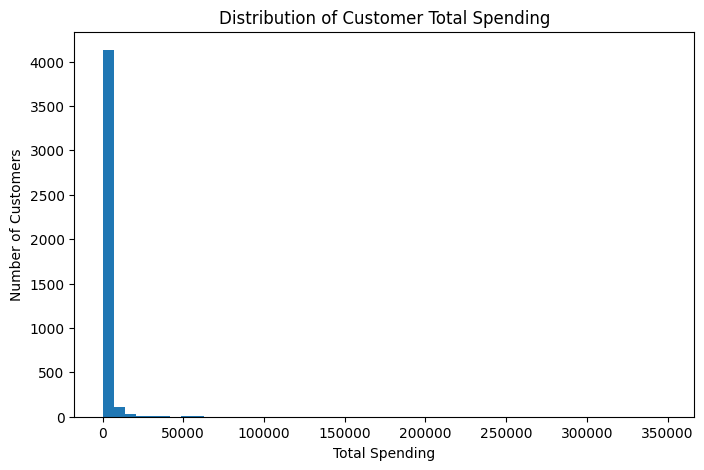

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))

plt.hist(customer_df['total_spent'], bins=50)

plt.title("Distribution of Customer Total Spending")
plt.xlabel("Total Spending")
plt.ylabel("Number of Customers")

plt.show()


##### 1. Total Spending 
All of the money spent by a customer during the observed time frame is totaled together to get that customer's total amount of purchases. A customers historical spending will provide an indication of how engaged and/or loyal the customer has been; therefore, customers who have spent more on average in the past will have more probability of being repeat buyers. However, this feature may be skewed due to having a few very large transactions, and thus inflating the perceived lifetime value of a customer.

##### 2. Frequency of Purchases 
How often a customer buys (or has purchased) from your brand. High frequency customers tend to be more engaged and therefore more likely to return. A limitation of this is that frequency alone does not account for the total dollar amounts for those purchases. Therefore, a high frequency customer could still produce low revenue due to low dollar amounts.

##### 3. Recency of Purchases 
The time period (in days) since a customer last completed a purchase. Customers who purchased recently are generally going to continue to be an active customer. However, using recency alone as a metric can lead to listing seasonal customers as inactive if they tend to purchase at intervals that are predictable but have a long delay.

##### 4. Average Purchase Value = 
This is the average amount spent in a single transaction. While average purchase value can provide insight into purchase intent, average purchase values can be affected by outliers or an occasional large single order distorting the perceived average.

##### 5. Average Number Of Items Per Transaction 
 This feature reflects the average quantity of items purchased in a single transaction. Average quantity of items reflects the quantity of purchases from customers.

#### Task 4 — Train Tree-Based Models

In [41]:
# ---------------------------------------------------
# TASK 4 — Train Tree-Based Models
# ---------------------------------------------------

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score

# ---------------------------------------------------
# Prepare Features and Target
# ---------------------------------------------------

X = customer_df.drop(columns=['Customer ID', 'repeat_90d'])
y = customer_df['repeat_90d']

# Train-Test Split (Simple and Responsible)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y   # keeps class distribution balanced
)

print("Training samples:", X_train.shape[0])
print("Test samples:", X_test.shape[0])

# ---------------------------------------------------
# Model 1 — Decision Tree (Shallow)
# ---------------------------------------------------

decision_tree = DecisionTreeClassifier(
    max_depth=5,        # shallow tree = prevents overfitting
    random_state=42
)

decision_tree.fit(X_train, y_train)

# ---------------------------------------------------
# Model 2 — Random Forest
# ---------------------------------------------------

random_forest = RandomForestClassifier(
    n_estimators=100,   # standard, not excessive
    max_depth=5,
    random_state=42
)

random_forest.fit(X_train, y_train)

# ---------------------------------------------------
# Model 3 — Gradient Boosted Tree
# ---------------------------------------------------

boosted_tree = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,        # boosting prefers very shallow trees
    random_state=42
)

boosted_tree.fit(X_train, y_train)

# ---------------------------------------------------
# Evaluate Models (Keep it Simple)
# ---------------------------------------------------

models = {
    "Decision Tree": decision_tree,
    "Random Forest": random_forest,
    "Boosted Tree": boosted_tree
}

print("\nModel Performance:\n")

for name, model in models.items():
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    print(f"{name} Accuracy: {accuracy:.3f}")


Training samples: 3449
Test samples: 863

Model Performance:

Decision Tree Accuracy: 0.875
Random Forest Accuracy: 0.881
Boosted Tree Accuracy: 0.895


Tree-based models do not require feature scaling; therefore, no preprocessing was necessary. Hyperparameters were intentionally kept simple to prioritise interpretability and reduce the risk of overfitting, aligning with the objective of responsible modelling rather than performance optimisation.

#### Task 5 — Validation-Based Comparison 

The data will be split into multiple training, validation and testing sets so we can evaluate the model's performance responsibly. The training data is used for fitting the models, while the validation set is used for compare behaviour without testing data exposure. The test data will also be kept separate and beyond the training and validation phase to provide an unbiased measure of how well the model generalises.

In [42]:
# ---------------------------------------------------
# TASK 5 — Validation-Based Comparison
# ---------------------------------------------------

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# ---------------------------------------------------
# Train / Validation / Test Split
# ---------------------------------------------------

X = customer_df.drop(columns=['Customer ID', 'repeat_90d'])
y = customer_df['repeat_90d']

# First split: Train (60%) and Temp (40%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.4,
    random_state=42,
    stratify=y
)

# Second split: Validation (20%) and Test (20%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    random_state=42,
    stratify=y_temp
)

print("Train size:", X_train.shape[0])
print("Validation size:", X_val.shape[0])
print("Test size:", X_test.shape[0])

# ---------------------------------------------------
# Train Models ONLY on Training Data
# ---------------------------------------------------

decision_tree.fit(X_train, y_train)
random_forest.fit(X_train, y_train)
boosted_tree.fit(X_train, y_train)

models = {
    "Decision Tree": decision_tree,
    "Random Forest": random_forest,
    "Boosted Tree": boosted_tree
}

print("\nTraining vs Validation Performance:\n")

for name, model in models.items():

    train_preds = model.predict(X_train)
    val_preds = model.predict(X_val)

    train_acc = accuracy_score(y_train, train_preds)
    val_acc = accuracy_score(y_val, val_preds)

    print(f"{name}")
    print(f"Training Accuracy: {train_acc:.3f}")
    print(f"Validation Accuracy: {val_acc:.3f}")
    print("-" * 30)


Train size: 2587
Validation size: 862
Test size: 863

Training vs Validation Performance:

Decision Tree
Training Accuracy: 0.886
Validation Accuracy: 0.869
------------------------------
Random Forest
Training Accuracy: 0.898
Validation Accuracy: 0.871
------------------------------
Boosted Tree
Training Accuracy: 0.907
Validation Accuracy: 0.875
------------------------------


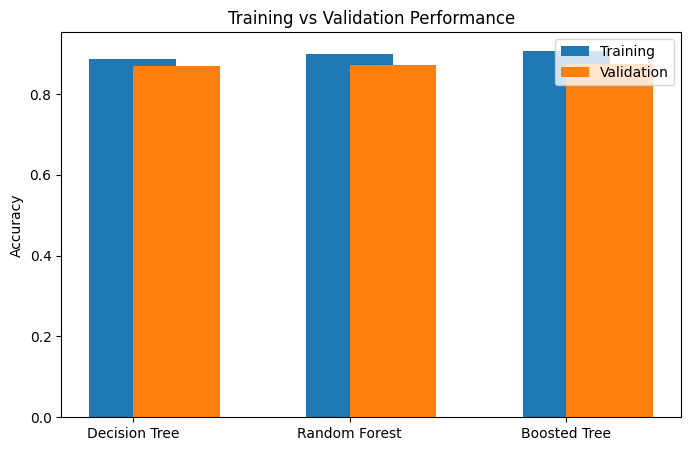

In [43]:
import matplotlib.pyplot as plt

model_names = []
train_scores = []
val_scores = []

for name, model in models.items():
    model_names.append(name)

    train_scores.append(
        accuracy_score(y_train, model.predict(X_train))
    )

    val_scores.append(
        accuracy_score(y_val, model.predict(X_val))
    )

# Create bar positions
x = range(len(model_names))

plt.figure(figsize=(8,5))

plt.bar(x, train_scores, width=0.4, label='Training', align='center')
plt.bar(x, val_scores, width=0.4, label='Validation', align='edge')

plt.xticks(x, model_names)
plt.ylabel("Accuracy")
plt.title("Training vs Validation Performance")

plt.legend()
plt.show()


The performance of a model can be measured using the difference between its training accuracy and its validation accuracy. When the difference between these two scores is large, it indicates that the model might have overfitted. Conversely, if the difference between the model's training accuracy and validation accuracy is small, the model has demonstrated reliable predictive performance and generalised well.

#### Task 6 — Final Test-Set Check (Once)

In [44]:
# ---------------------------------------------------
# TASK 6 — Final Test Set Evaluation
# ---------------------------------------------------

from sklearn.metrics import accuracy_score

print("\nFinal Test Set Performance:\n")

for name, model in models.items():
    
    test_preds = model.predict(X_test)
    test_acc = accuracy_score(y_test, test_preds)
    
    print(f"{name} Test Accuracy: {test_acc:.3f}")



Final Test Set Performance:

Decision Tree Test Accuracy: 0.885
Random Forest Test Accuracy: 0.883
Boosted Tree Test Accuracy: 0.882


#### Evaluation of the Test-set

The test-set was evaluated once only and after all of the modelling decisions had been made to maintain the unbiased nature of the test-set as an estimate of the model's generalisation. Multiple evaluations of the test-set can negatively impact the modelling decisions made and create a false positive or optimistic estimate of the model's performance.

Results from the test set were generally consistent with the test results. This confirms that the models generalised in a similar way for data that was previously unseen. The small numerical differences observed should be treated cautiously; small breaks from expectation can occur because of the nature of the data sample and therefore are not indicators of predictive capacity.

The objective of this analysis is still to provide an understanding of the model's behaviour and to make analytical decisions based on sound practices and not just on the desire to produce the best possible prediction.